In [ ]:
grimport pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
predictions= pd.read_csv('predictions.csv')
results= pd.read_csv('game_results.csv')
users= pd.read_csv('users.csv')

# Задание 1

In [ ]:
results['timestamp'] = pd.to_datetime(results.timestamp)
users['create_time'] = pd.to_datetime(users.create_time)
users.rename(columns={'id': 'user_id'}, inplace=True)
predictions.rename(columns={'id': 'user_id'}, inplace=True)

Проверка на пропущенные значения




In [ ]:
results.isna().sum()

id              0
user_id         0
timestamp       0
winner          0
length          0
magic_used      0
player_cards    0
round           0
type            0
dtype: int64

In [ ]:
predictions.isna().sum()

user_id       0
prediction    0
dtype: int64

In [ ]:
users.isna().sum()

user_id        0
create_time    0
dtype: int64

Общая информация по данным

In [ ]:
results.user_id.nunique()

5289

In [ ]:
users.user_id.nunique()

4899

In [ ]:
users.describe()

,user_id
count,4899.000000
mean,226364.241070
std,4675.010082
min,218490.000000
25%,222367.500000
50%,226189.000000
75%,230372.000000
max,234754.000000


In [ ]:
results.describe()

,id,user_id,winner,length,magic_used,player_cards,round,type
count,8.127330e+05,812733.000000,812733.000000,812733.000000,812733.000000,812733.00000,812733.000000,812733.000000
mean,9.971101e+06,226233.891426,0.819289,195.261083,0.144990,26.81591,1.863282,1.162766
std,4.354077e+06,4724.630244,0.384779,100.548128,0.586117,20.47685,0.808618,0.382593
min,2.187140e+05,218490.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,6.773015e+06,222209.000000,1.000000,137.000000,0.000000,8.00000,1.000000,1.000000
50%,1.015677e+07,225946.000000,1.000000,176.000000,0.000000,17.00000,2.000000,1.000000
75%,1.327150e+07,230377.000000,1.000000,227.000000,0.000000,52.00000,3.000000,1.000000
max,1.921282e+07,234754.000000,1.000000,19437.000000,25.000000,52.00000,6.000000,4.000000


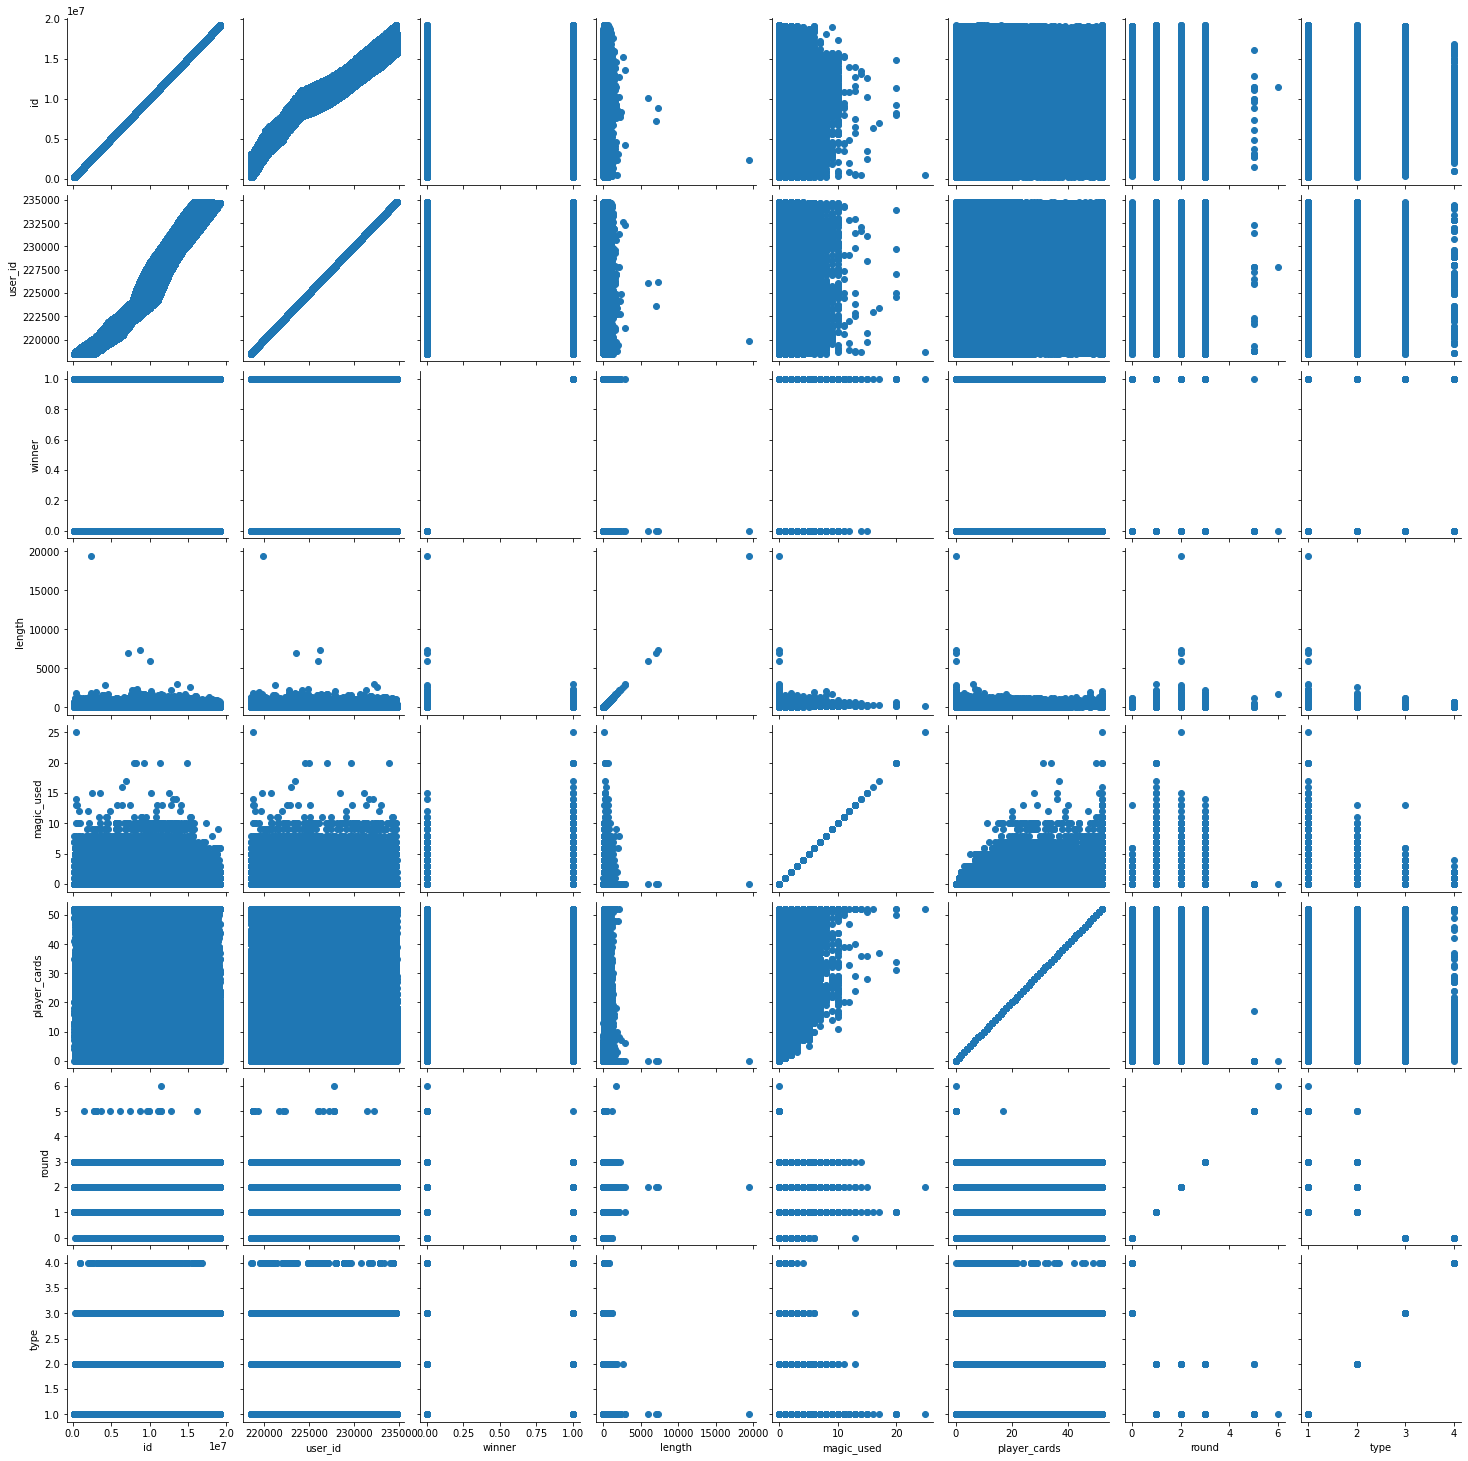

In [ ]:
pair_grid_plot = sns.PairGrid(results)
pair_grid_plot.map(plt.scatter);

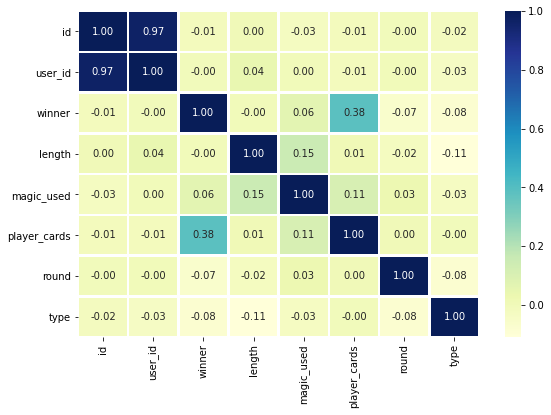

In [ ]:
corr = results.corr()
f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax,  cmap="YlGnBu")
plt.show()

In [ ]:
full_table=results.merge(users, left_on='user_id',  right_on='user_id')

In [ ]:
full_table['edge'] = full_table.create_time + timedelta(hours=24)

In [ ]:
table = full_table[full_table['timestamp'] <= full_table['edge']]

In [ ]:
table.describe()

,id,user_id,winner,length,magic_used,player_cards,round,type
count,6.337300e+04,63373.000000,63373.000000,63373.000000,63373.000000,63373.000000,63373.000000,63373.000000
mean,8.436394e+06,226157.999022,0.865952,243.418128,0.654285,31.201426,1.893993,1.086299
std,4.269840e+06,4804.250479,0.340706,154.903685,1.337843,20.725312,0.817191,0.303128
min,2.187140e+05,218490.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,4.971035e+06,222055.000000,1.000000,164.000000,0.000000,10.000000,1.000000,1.000000
50%,8.676189e+06,225919.000000,1.000000,219.000000,0.000000,32.000000,2.000000,1.000000
75%,1.193158e+07,230319.000000,1.000000,284.000000,1.000000,52.000000,3.000000,1.000000
max,1.587660e+07,234754.000000,1.000000,19437.000000,25.000000,52.000000,5.000000,4.000000


In [ ]:
table.user_id.nunique()

4670

In [ ]:
user_features=table.drop(['id','timestamp','create_time','edge'], axis=1)

In [ ]:
user_features.head()

,user_id,winner,length,magic_used,player_cards,round,type
0,218490,1.0,375.0,7.0,52.0,1.0,1.0
1,218490,1.0,475.0,3.0,41.0,2.0,1.0
2,218490,1.0,476.0,0.0,13.0,3.0,1.0
3,218490,1.0,329.0,2.0,52.0,1.0,1.0
4,218490,1.0,389.0,2.0,20.0,2.0,1.0


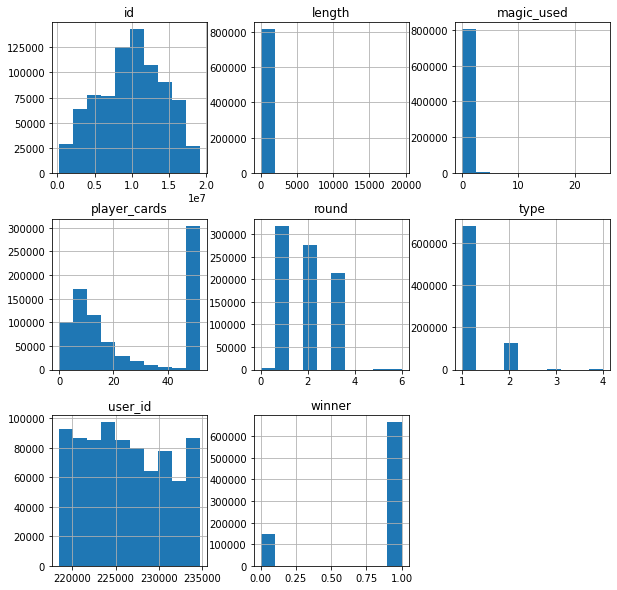

In [ ]:
results.hist(figsize=(10,10),bins=10);

In [ ]:
user_features.to_csv('user_features.csv')

# Задание 2

In [ ]:
from sklearn import tree, ensemble, linear_model, preprocessing
from sklearn.tree import DecisionTreeClassifier
from graphviz import Source
import os
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from IPython.display import display, SVG, Image
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, mean_squared_error, r2_score

In [ ]:
with_predictions = user_features.merge(predictions, left_on='user_id',  right_on='user_id',how='left')

In [ ]:
with_predictions_mean = with_predictions.groupby('user_id').mean()
with_predictions_median = with_predictions.groupby('user_id').median()

In [ ]:
train_set = with_predictions_mean[with_predictions_mean['prediction'].isna()==False]
test_set = with_predictions_mean[with_predictions_mean['prediction'].isna()==True]
train_set_parameters = train_set[['winner', 'round','player_cards']]
train_set_predictions = train_set['prediction']
test_set_parameters = test_set[['winner', 'round','player_cards']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_set_parameters, train_set_predictions, test_size=0.4)

`Дерево решений`

In [ ]:
my_tree = DecisionTreeClassifier(criterion='entropy')
cross_val_score(my_tree, X_train, y_train, cv=3).mean()

0.6401756936871441

In [ ]:
my_tree.fit(X_train,y_train)
X_test['predicted_with_tree'] = my_tree.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
clf=BaggingClassifier()
bagging = BaggingClassifier(base_estimator=clf, n_estimators=100, max_features=int((X_train.shape[1])**0.5)).fit(X_train,y_train)
cross_val_score(bagging, X_train, y_train, cv=3).mean()
X_test['predicted_with_bagging'] = bagging.predict(X_test.iloc[:,0:3])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
forest = ensemble.RandomForestClassifier()
cross_val_score(forest, X_train, y_train, cv=3).mean()


0.6656052344601964

In [ ]:
parameters={'n_estimators':[10,20,30], 'max_depth':[2,5,7,10],'min_samples_leaf':range(1,7),
            'min_samples_split':range(2,9,2)}
grid_search_cv_clf=GridSearchCV(forest,parameters,cv=3).fit(X_train, y_train)
best_clf = grid_search_cv_clf.best_estimator_
feature_importances = best_clf.feature_importances_
pd.DataFrame({'features': list(X_train),'feature_importances': feature_importances}).sort_values('feature_importances', ascending=False)

,features,feature_importances
1,round,0.444281
0,winner,0.300446
2,player_cards,0.255273


In [ ]:
forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
X_test['predicted_with_forest'] = forest.predict(X_test.iloc[:,0:3])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,10,1), "penalty":["l1","l2","elasticnet"],"class_weight" : ["None","balanced"],"solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=3)
logreg_cv.fit(X_train,y_train)
logreg_cv.best_estimator_
clf = LogisticRegression(C=0.5, class_weight='balanced', penalty='l2',
                    solver='lbfgs').fit(X_train,y_train)
X_test['predicted_with_logreg']=clf.predict(X_test.iloc[:,:3])


In [ ]:
print('Training set:')
for actual, predicted, descr in zip([my_tree.predict(X_train), bagging.predict(X_train), forest.predict(X_train),clf.predict(X_train)], 
                                    [y_train,y_train,y_train,y_train], 
                                    ["predicted_with_tree:", "predicted_with_bagging:", "predicted_with_forest:","predicted with logistic regression:"]):
    print(descr, "accuracy =", round(accuracy_score(actual, predicted),3))
    print(descr, "recall =", round(recall_score(actual, predicted),3))
    print(descr, "precision =", round(precision_score(actual, predicted),3))
    print(descr, "f1 =", round(f1_score(actual, predicted),3))
    print(descr, "roc_auc_score =", round(roc_auc_score(actual, predicted),3))
print()

print('Test set:')
for actual, predicted, descr in zip([X_test['predicted_with_tree'], X_test['predicted_with_bagging'], X_test['predicted_with_forest'],X_test['predicted_with_logreg']], 
                                    [y_test,y_test,y_test], 
                                    ["predicted_with_tree:", "predicted_with_bagging:", "predicted_with_forest:","predicted with logistic regression:"]):
    print(descr, "accuracy =", round(accuracy_score(actual, predicted),3))
    print(descr, "recall =", round(recall_score(actual, predicted),3))
    print(descr, "precision =", round(precision_score(actual, predicted),3))
    print(descr, "f1 =", round(f1_score(actual, predicted),3))
    print(descr, "roc_auc_score =", round(roc_auc_score(actual, predicted),3))


Training set:
predicted_with_tree: accuracy = 0.863
predicted_with_tree: recall = 0.88
predicted_with_tree: precision = 0.61
predicted_with_tree: f1 = 0.72
predicted_with_tree: roc_auc_score = 0.869
predicted_with_bagging: accuracy = 0.744
predicted_with_bagging: recall = 0.715
predicted_with_bagging: precision = 0.193
predicted_with_bagging: f1 = 0.304
predicted_with_bagging: roc_auc_score = 0.731
predicted_with_forest: accuracy = 0.863
predicted_with_forest: recall = 0.851
predicted_with_forest: precision = 0.638
predicted_with_forest: f1 = 0.729
predicted_with_forest: roc_auc_score = 0.858
predicted with logistic regression: accuracy = 0.618
predicted with logistic regression: recall = 0.387
predicted with logistic regression: precision = 0.544
predicted with logistic regression: f1 = 0.452
predicted with logistic regression: roc_auc_score = 0.582

Test set:
predicted_with_tree: accuracy = 0.669
predicted_with_tree: recall = 0.323
predicted_with_tree: precision = 0.23
predicted_with

In [ ]:
confusion_matrix(y_test,X_test['predicted_with_forest'])

array([[657, 115],
       [213,  65]])

In [ ]:
confusion_matrix(y_test,X_test['predicted_with_tree'])

array([[638, 134],
       [214,  64]])

In [ ]:
confusion_matrix(y_test,X_test['predicted_with_bagging'])

array([[734,  38],
       [244,  34]])

In [ ]:

confusion_matrix(y_test,clf.predict(X_test.iloc[:,:3]))

array([[499, 273],
       [153, 125]])

In [ ]:
test_set['predicted_with_tree'] = my_tree.predict(test_set[['winner', 'round', 'player_cards']])
test_set['predicted_with_bagging'] = bagging.predict(test_set[['winner', 'round', 'player_cards']])
test_set['predicted_with_logreg']=clf.predict(test_set[['winner', 'round', 'player_cards']])
test_set['predicted_with_forest'] = forest.predict(test_set[['winner', 'round', 'player_cards']])

In [ ]:
test_set.drop(['prediction'],axis=1,inplace=True)
test_set.to_csv('predictions.csv')